In [1]:
library(reticulate)
use_condaenv(condaenv="pyr2", conda="/data8t_0/hms/anaconda3/bin/conda")
# use_python("/data8t_0/hms/anaconda3/envs/pyr2/bin/python")
# umap<-import('umap')

In [2]:
library(Seurat)
library(data.table)
library(ggplot2)
library(flexclust)
suppressMessages(suppressWarnings(library(stringr)))
suppressMessages(suppressWarnings(library(dplyr)))
datasetName = "stomach_stomach_HCLFetalStomach2"
dataFormat = 'tsv'
setwd(paste0("/stor/public/hcad/db_v1/",datasetName,"/"))

Loading required package: grid

Loading required package: lattice

Loading required package: modeltools

Loading required package: stats4



In [4]:
# Load the organized dataset
if(dataFormat == 'tsv'){
    data.matrix <- read.table(paste0(datasetName,"_expression.tsv.gz"),h = T,sep='\t',row.names = 1)
} else{
   system(paste0("tar -zxvf ", datasetName, "_expression.tsv.gz")) #Invoke the unix command
   data.matrix <- Read10X(data.dir = paste0(datasetName,"_expression"))
   # data.dir: Directory containing the matrix.mtx, genes.tsv (or features.tsv), and barcodes.tsv files provided by 10X.
}
# Load the metadata and annotation
data.metadata <- read.table(file = paste0(datasetName,"_metadata.tsv"), h = T, sep = "\t", row.names = 5)
data.annotation <- read.table(file = paste0(datasetName,"_annotation.tsv"), h = T, sep = "\t", row.names = 1)
if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    data.annotation2 <- read.table(file = paste0(datasetName,"_annotation2.tsv"), h = T, sep = "\t", row.names = 1)
}

Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


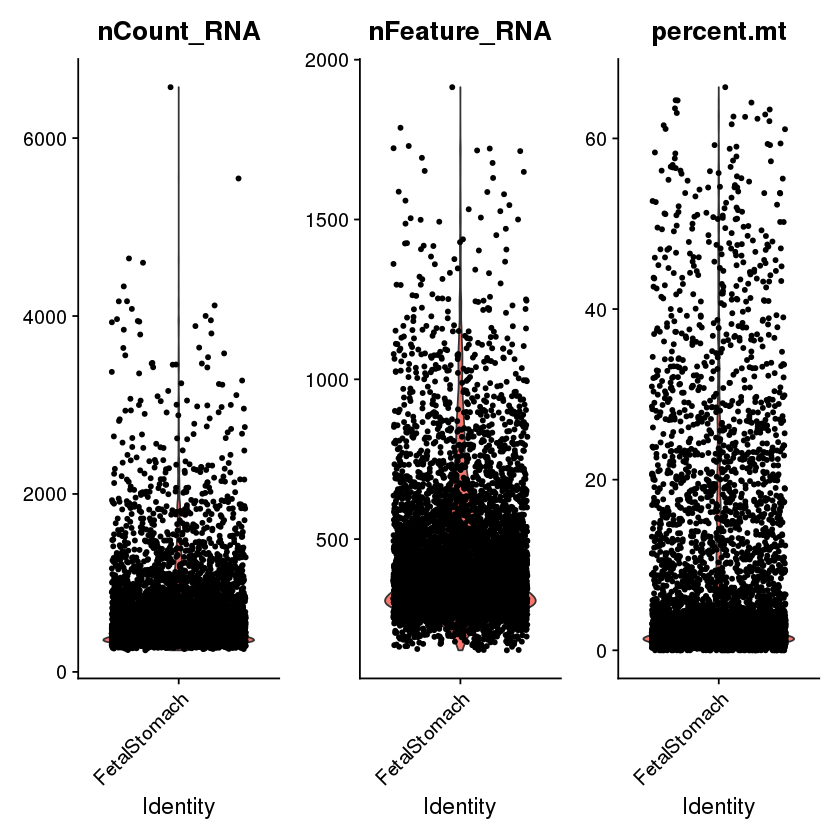

In [5]:
# Pre-processing
min.features = 20
# Modify the default value of these parameters according to original paper
dataobj <- CreateSeuratObject(counts = data.matrix, project = datasetName, min.features = min.features, meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)

if (file.exists(paste0(datasetName,"_annotation2.tsv"))) {
    dataobj <- AddMetaData(dataobj, metadata = data.annotation2)
}
dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
VlnPlot(object = dataobj, features= c("nCount_RNA","nFeature_RNA","percent.mt"))

In [6]:
percent.mt.thre = 45
nFeature_RNA_range = c(min.features, 1500)
dataobj <- subset(dataobj, subset = nFeature_RNA > nFeature_RNA_range[1] & nFeature_RNA < nFeature_RNA_range[2] & percent.mt < percent.mt.thre)

In [7]:
warnings('off')
dataobj <- NormalizeData(dataobj, normalization.method = "LogNormalize", scale.factor = 10000)

In [8]:
# *--------------------Load reference table--------------------*
print("=========Loading Reference Table=========")
ref_table_raw <- read.csv("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/GeneSymbolRef_SelectAll_upd0731.csv", header=TRUE, na.strings=TRUE, stringsAsFactors=FALSE)
# print(dim(ref_table_raw))
print("Finished")
# *--------------------Load total gene list--------------------*
print("=========Processing Gene List=========")
total_gene_list_raw = read.table("/data8t_0/hms/workspace/HCA-d/Rtoolkit_GeneSymbolUniform/total_gene_list_43878.txt", 
                                 header=TRUE, sep='\t', fill=TRUE, stringsAsFactors=FALSE)
total_gene_list = total_gene_list_raw[,1]
# Seurat changes all "_" to "-".
total_gene_list <- str_replace(total_gene_list, "_", "-")
print("The length of gene list is: ")
print(length(total_gene_list))
print("Finished")
print("=========Processing Reference Table=========")
# Separate dataframe to previous and alias symbol sub-dataframe
# Remove duplicates and empty values
ref_table_raw <- ref_table_raw[,c("Approved.symbol","Alias.symbol","Previous.symbol")]
ref_table <- ref_table_raw[ref_table_raw[,"Previous.symbol"]!="" | ref_table_raw[,"Alias.symbol"]!="",]
# Seurat changes all "_" to "-".
ref_table$Previous.symbol <- str_replace(ref_table$Previous.symbol, "_", "-")
ref_table$Alias.symbol <- str_replace(ref_table$Alias.symbol, "_", "-")
ref_table$Approved.symbol <- str_replace(ref_table$Approved.symbol, "_", "-")
# print(dim(ref_table))
ref_table_prev <- unique(ref_table[,c("Approved.symbol","Previous.symbol")])
ref_table_prev <- ref_table_prev[ref_table_prev[,"Previous.symbol"]!="",]
ref_table_alia <- unique(ref_table[,c("Approved.symbol","Alias.symbol")])
ref_table_alia <- ref_table_alia[ref_table_alia[,"Alias.symbol"]!="",]
# print(dim(ref_table_prev))
# print(dim(ref_table_alia))
print("Finished")

# *--------------------Load query data--------------------*
print("=========Loading Query Data=========")
query_data <- as.data.frame(as.matrix(dataobj@assays$RNA@data))
query_gene_list <- rownames(dataobj)
print("The shape of query data is: ")
print(dim(query_data))
print("Print out first 5 genes in query data, in case something wrong happens in data loading: ")
print(query_gene_list[1:5])
print("Finished")

# *--------------------Perform gene name uniform--------------------*
print("=========Performing Gene Symbol Uniform=========")
print("Performing gene symbol uniform, this step may take several minutes")
gene_appearance_list <- data.frame(gene_name=total_gene_list, appearance=rep(FALSE, length(total_gene_list)))
outlier_gene_list <- c()

result_data <- query_data
result_data$genenames <- rownames(result_data)
report <- data.frame(Original.Name=character(), Modified.Name=character(), Status=character(), stringsAsFactors=FALSE)

for (i in c(1:length(query_gene_list))){
  gene_name <- query_gene_list[i]
  # Modify gene symbols, both "Alias symbol" and "Previous symbol" are used. 
  if(sum(ref_table_prev["Previous.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_prev["Previous.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_prev[ref_table_prev[,"Previous.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
    
  else if(sum(ref_table_alia["Alias.symbol"]==gene_name)>0){
    # Multiple names matched
    if(sum(ref_table_alia["Alias.symbol"]==gene_name)>1){
      candidate_names <- paste(ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"], collapse='|')
      report[i,] <- c(gene_name, candidate_names, "Multiple Candidates")
      if(gene_name %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, gene_name)
      }
    }
    # Only one name matched
    else{
      candidate_names <- ref_table_alia[ref_table_alia[,"Alias.symbol"]==gene_name,"Approved.symbol"]
      result_data[i:dim(result_data)[1],"genenames"][result_data[i:dim(result_data)[1],"genenames"]==gene_name] <- candidate_names
      report[i,] <- c(gene_name, candidate_names, "Changed")
      if(candidate_names %in% total_gene_list){
        gene_appearance_list[gene_appearance_list[,"gene_name"]==candidate_names,"appearance"] = TRUE
      }
      else{
        outlier_gene_list <- c(outlier_gene_list, candidate_names)
      }
    }
  }
  
  # Gene name not found
  else{
    report[i,] <- c(gene_name, gene_name, "No Change")
    if(gene_name %in% total_gene_list){
      gene_appearance_list[gene_appearance_list[,"gene_name"]==gene_name,"appearance"] = TRUE
    }
    else{
      outlier_gene_list <- c(outlier_gene_list, gene_name)
    }
  }
}
print("Finished")

# *--------------------Construct uniform output--------------------*
print("=========Building Output Matrix=========")
result_data_grouped <- result_data %>% group_by(genenames) %>% summarise_at(vars(-group_cols()), mean)
result_data_sub <- as.data.frame(result_data_grouped)[which(!result_data_grouped$genenames %in% outlier_gene_list),]
result_data_out <- subset(result_data_sub, select = -genenames )
rownames(result_data_out) <- result_data_sub$genenames
print("Shape of processed query data: ")
print(dim(result_data_out))

add_df <- data.frame(matrix(nrow=sum(gene_appearance_list$appearance==FALSE),ncol=dim(result_data)[2]-1, 0))
rownames(add_df) <- gene_appearance_list$gene_name[!gene_appearance_list$appearance]
colnames(add_df) <- colnames(result_data_out)

result_data_out <- rbind(result_data_out, add_df)
print("Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged.")
print(dim(result_data_out))
print("Finished")

[1] "=========Loading Reference Table========="
[1] "Finished"
[1] "=========Processing Gene List========="
[1] "The length of gene list is: "
[1] 43878
[1] "Finished"
[1] "=========Processing Reference Table========="
[1] "Finished"
[1] "=========Loading Query Data========="
[1] "The shape of query data is: "
[1] 24428  6475
[1] "Print out first 5 genes in query data, in case something wrong happens in data loading: "
[1] "A1BG"     "A1BG-AS1" "A1CF"     "A2M"      "A2M-AS1" 
[1] "Finished"
[1] "=========Performing Gene Symbol Uniform========="
[1] "Performing gene symbol uniform, this step may take several minutes"
[1] "Finished"
[1] "=========Building Output Matrix========="
[1] "Shape of processed query data: "
[1] 18948  6475
[1] "Shape of output data after adding zero-value genes. It should have 43878 genes with cell number unchanged."
[1] 43878  6475
[1] "Finished"


In [9]:
dataobj <- CreateSeuratObject(result_data_out,meta.data = data.metadata)
dataobj <- AddMetaData(dataobj, metadata = data.annotation)
dataobj <- FindVariableFeatures(dataobj) # default feature number, nfeatures = 2000
dataobj <- ScaleData(dataobj, features = VariableFeatures(dataobj))
# dataobj[["percent.mt"]] <- PercentageFeatureSet(dataobj, pattern = "^[Mm][Tt]")
# 2. run sctransform 
# dataobj <- SCTransform(dataobj, vars.to.regress = "percent.mt", do.correct.umi = TRUE, do.scale = TRUE, do.center = TRUE)

dataobj <- AddMetaData(dataobj, metadata = data.metadata)

Warning message in CreateSeuratObject(result_data_out, meta.data = data.metadata):
“Some cells in meta.data not present in provided counts matrix.”
Centering and scaling data matrix



PC_ 1 
Positive:  COL1A1, OLFML3, LUM, TNC, MFAP4, GPC6, COL5A1, RGS2, FBLN1, LTBP4 
	   TMSB15A, LINC01082, PTN, TUBA1A, ABI3BP, PLAC9, TNFAIP6, ID3, VCAN, GPC3 
	   CXCL12, FBN2, MEG3, SPON2, VSTM4, SOCS3, POSTN, ISLR, PCLAF, NELL1 
Negative:  MT-CO1, RPS29, RPS27, MT-CO3, RPL31, RPS14, MT-ND4, RPL39, MT-ATP6, RPS6 
	   RPS18, RPL34, RPL11, TMSB4X, RPL37A, RPL41, RPL37, RPS3A, RPS27A, RPS23 
	   MT-CO2, RPL26, RPL7, RPS21, RPS3, SPINK1, RPS19, RPL21, RPLP2, RPL27A 
PC_ 2 
Positive:  CD74, HLA-DRA, SRGN, HLA-DRB1, TYROBP, FCER1G, CCL4, AIF1, C1QB, C1QA 
	   RGS1, GPR183, HLA-DPA1, CCL4L2, HLA-DPB1, CXCL8, C1QC, CCL3, CCL3L3, LST1 
	   HLA-DQB1, CST3, MS4A6A, IL1B, LYVE1, C5AR1, BCL2A1, FOLR2, DAB2, F13A1 
Negative:  COL1A2, DCN, COL1A1, COL3A1, SPARC, FOSB, LUM, OLFML3, GPC3, EEF1A1 
	   ZFP36, FBLN1, COL5A1, MFAP4, LGALS1, EIF1, HNRNPA1, RPL6, RPL13A, DNAJA1 
	   PTN, FOS, DLK1, RPL10A, RPL35A, PTMA, RPL7, GPC6, RPL9, RPL5 
PC_ 3 
Positive:  CD74, HLA-DRA, HLA-DRB1, AIF1, TYROBP, SRG

png 
  2

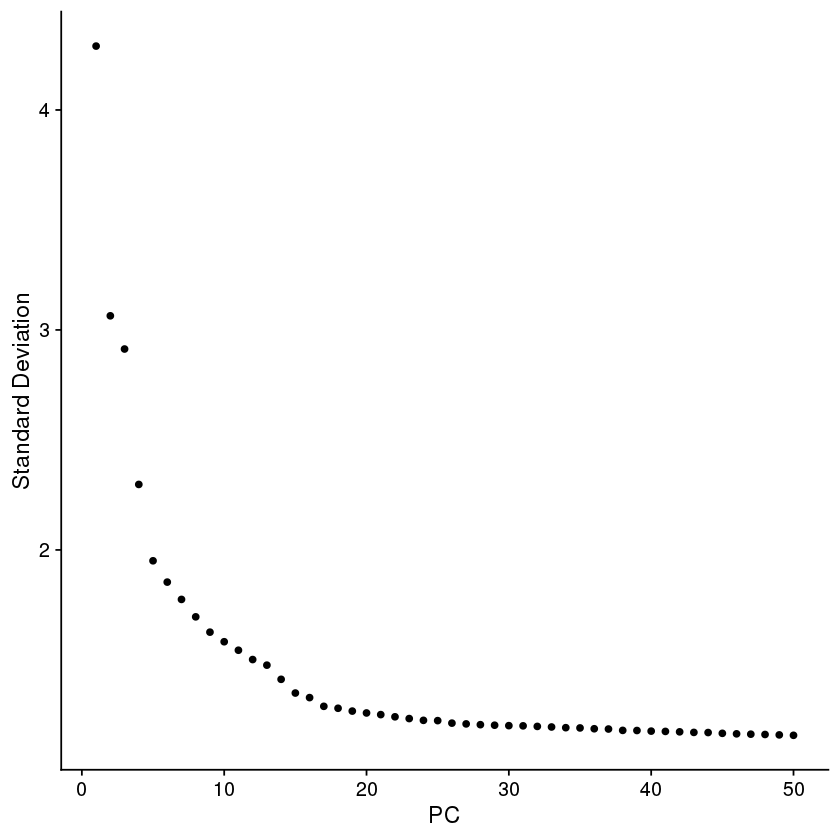

In [10]:
# Dimensional Reduction
dataobj <- RunPCA(dataobj, features = VariableFeatures(object = dataobj),npcs=50)
# Determine the ‘dimensionality’ of the dataset according to elbow plot
pdf(paste0(datasetName,"seurat.elbowplot.pdf"))
ElbowPlot(dataobj,ndim=50) 
dev.off()
ElbowPlot(dataobj,ndim=50) 

In [9]:
pcDim = 30 # set as 75 in this case 

In [11]:
pcDim = 30 # set as 75 in this case 

# Cluster the cells
dataobj <- FindNeighbors(dataobj, reduction = "pca", dims = 1:pcDim, nn.eps = 0.5)

Computing nearest neighbor graph

Computing SNN



In [12]:
dataobj <- FindClusters(dataobj, resolution = 0.5, n.start = 5)
randIndex(dataobj$cell_cluster,dataobj$seurat_clusters)

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 6475
Number of edges: 257145

Running Louvain algorithm...
Maximum modularity in 5 random starts: 0.8088
Number of communities: 12
Elapsed time: 0 seconds


ARI 
0.3860032

In [13]:
dataobj <- RunUMAP(dataobj,dims=1:pcDim)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
10:56:33 UMAP embedding parameters a = 0.9922 b = 1.112

10:56:33 Read 6475 rows and found 30 numeric columns

10:56:33 Using Annoy for neighbor search, n_neighbors = 30

10:56:33 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

10:56:35 Writing NN index file to temp file /tmp/RtmpBDH7kP/file6faa7cfe310d

10:56:35 Searching Annoy index using 1 thread, search_k = 3000

10:56:37 Annoy recall = 100%

10:56:38 Commencing smooth kNN distance calibration using 1 thread

10:56:39 Initializing fr

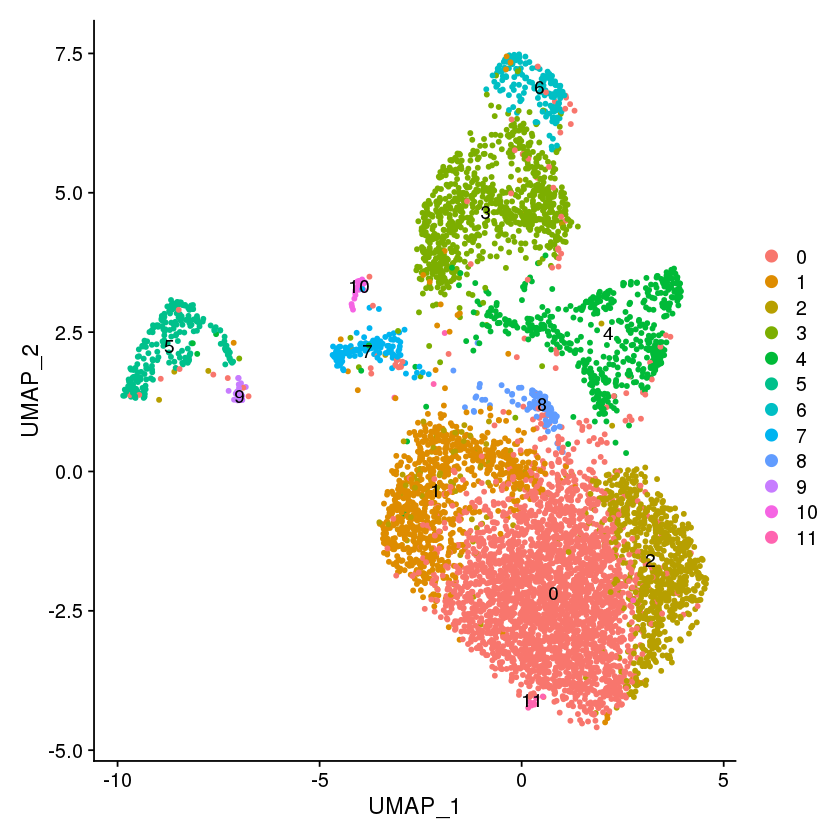

In [16]:
p_umap=DimPlot(dataobj,label = TRUE, pt.size=1)
ggsave(paste0(datasetName,".seurat.umap.tiff"), plot = p_umap, width = 8, height = 5)
p_umap

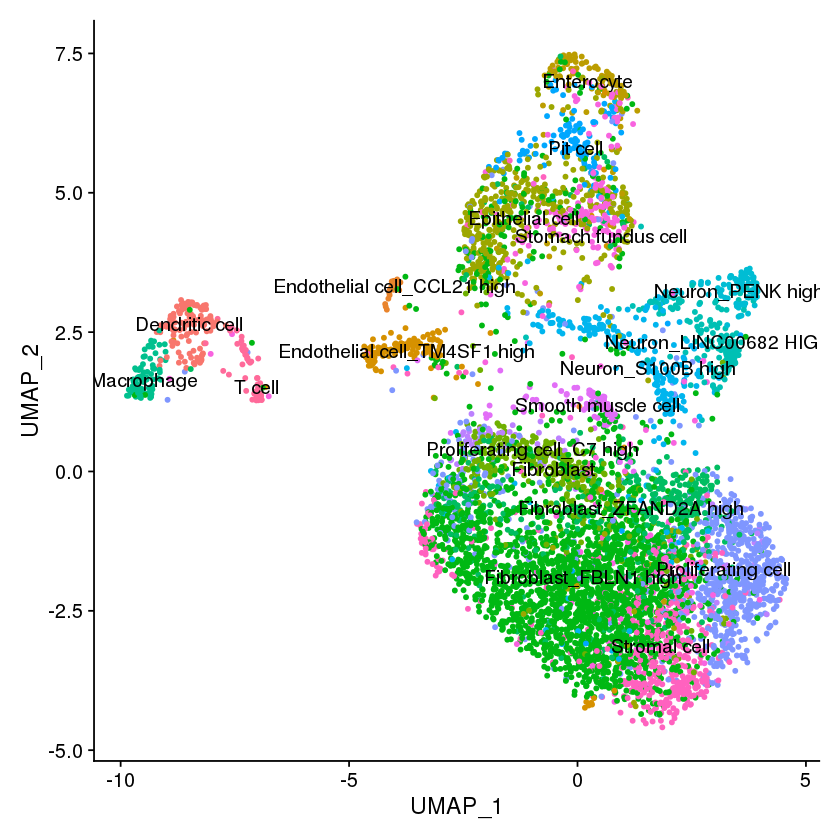

In [15]:
p_umap2 <- DimPlot(dataobj, reduction = "umap", label = T, group.by = "cell_cluster", pt.size=1)+NoLegend()
ggsave(paste0(datasetName,".seurat.umap_orig.tiff"), plot = p_umap2, width = 8, height = 5)
p_umap2

In [31]:
new.cluster.ids <- c("Stomach-Connective tissue-Fibroblast-FBLN1", 
                     "Stomach-Connective tissue-Fibroblast-COL1A2", 
                     "Stomach-Connective tissue-Fibroblast-FBLN1", 
                     "Stomach-Epithelial tissue-Epithelial cell-AGR2",
                     "Stomach-Nerve tissue-Neuron-STMN2",
                     "Stomach-Connective tissue-Dendritic cell-HLA-DRA C1QA",
                     "Stomach-Epithelial tissue-Enterocyte-AGR3",
                     "Stomach-Epithelial tissue-Endothelial cell-FLT1",
                     "Stomach-Muscle tissue-smooth muscle cell-MYL9",
                     "Stomach-Connective tissue-T cell-KLRB1",
                     "Stomach-Epithelial tissue-Endothelial cell-CCL21",
                     "Stomach-Connective tissue-Fibroblast-FBLN1"
                    )

In [20]:
subset(dataobj.markers,cluster=='')
# subset(dataobj.markers,gene=='NUPR1')

,p_val,avg_logFC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
JUNB,2.399415e-75,0.6571776,0.626,0.527,1.052815e-70,Unclassified,JUNB
MFAP4,9.404335e-62,0.9337523,0.351,0.198,4.126434e-57,Unclassified,MFAP4
LUM1,1.379820e-58,0.7149858,0.428,0.282,6.054374e-54,Unclassified,LUM
COL1A11,4.735928e-55,0.4216128,0.575,0.427,2.078030e-50,Unclassified,COL1A1
TNC,3.685188e-54,0.9531319,0.301,0.160,1.616987e-49,Unclassified,TNC
RGS21,3.773467e-54,0.7292102,0.462,0.344,1.655722e-49,Unclassified,RGS2
OLFML31,6.591296e-47,0.7134163,0.395,0.273,2.892129e-42,Unclassified,OLFML3
GPC6,2.414596e-44,0.8779062,0.293,0.171,1.059476e-39,Unclassified,GPC6
IFITM3,2.589067e-39,0.5103309,0.553,0.505,1.136031e-34,Unclassified,IFITM3


In [32]:
names(x = new.cluster.ids) <- levels(x = dataobj)
annodataobj <- RenameIdents(object = dataobj, new.cluster.ids)

In [33]:
rr2 <- RunUMAP(annodataobj,dims=1:pcDim)

11:10:51 UMAP embedding parameters a = 0.9922 b = 1.112

11:10:52 Read 6475 rows and found 30 numeric columns

11:10:52 Using Annoy for neighbor search, n_neighbors = 30

11:10:52 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

11:10:54 Writing NN index file to temp file /tmp/RtmpBDH7kP/file6faa6ab3b3a9

11:10:54 Searching Annoy index using 1 thread, search_k = 3000

11:10:56 Annoy recall = 100%

11:10:56 Commencing smooth kNN distance calibration using 1 thread

11:10:58 Initializing from normalized Laplacian + noise

11:10:58 Commencing optimization for 500 epochs, with 276430 positive edges

11:11:21 Optimization finished



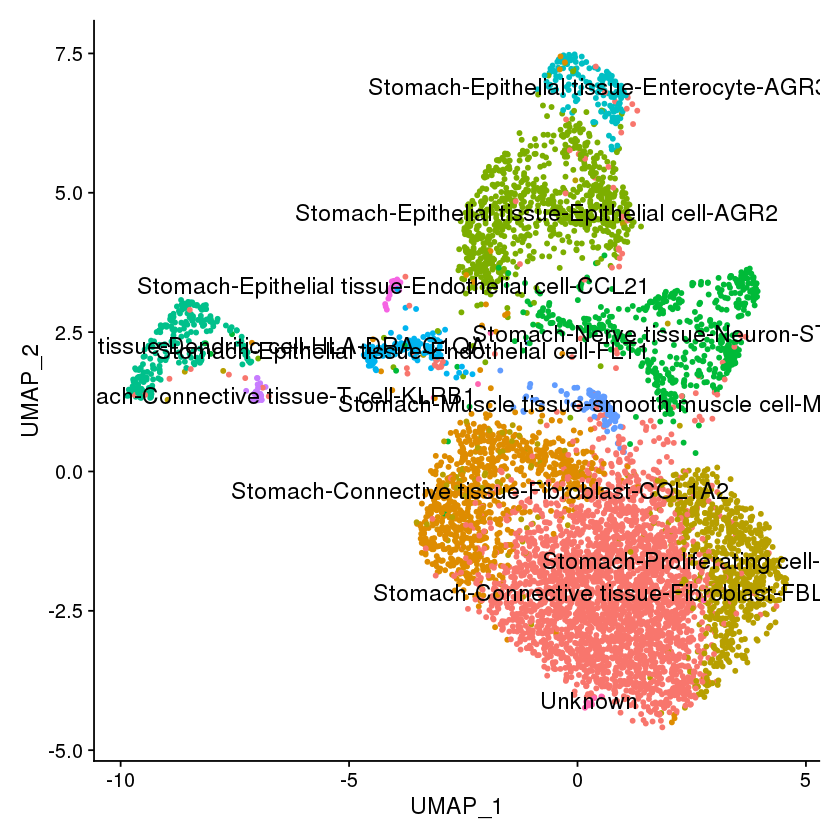

In [34]:
p_umap4 <- UMAPPlot(rr2,label = T, pt.size=1,label.size=5)+NoLegend()
# LabelClusters(plot = p_umap4, id = 'ident', color = 'white')
ggsave(paste0(datasetName,".seurat.umap_hcad.tiff"), plot = p_umap4, width = 25, height = 15)
p_umap4

In [19]:
dataobj.markers <- FindAllMarkers(dataobj, only.pos = TRUE)

Calculating cluster Stomach-Epithelial tissue-Epithelial cell-AGR2

Calculating cluster Stomach-Epithelial tissue-Enterocyte-AGR3

Calculating cluster Stomach-Connective tissue-Fibroblast-COL1A2

Calculating cluster Stomach-Nerve tissue-Neuron-STMN2

Calculating cluster Stomach-Connective tissue-Dendritic cell-HLA-DRA C1QA

Calculating cluster Unclassified

Calculating cluster Stomach-Epithelial tissue-Endothelial cell-FLT1

Calculating cluster Stomach-Epithelial tissue-Endothelial cell-CCL21

Calculating cluster Stomach-Muscle tissue-Smooth muscle cell-MYL9

Calculating cluster Stomach-Connective tissue-T cell-KLRB1



In [22]:
write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(dataobj$seurat_clusters),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [35]:

write.table(dataobj.markers, file = paste0(datasetName,".seurat.markers.txt"), sep = "\t", quote = F, row.names = F, col.names = T)
# 
dataobj<-AddMetaData(dataobj, metadata =as.character(annodataobj@active.ident),col.name='hcad.label') 

write.table(cbind(colnames(dataobj), dataobj$hcad.label), file = paste0(datasetName,"_annotation.hcad.tsv"), sep = "\t", quote = F, row.names = F, col.names = c('cell_ID','cell_cluster'))

saveRDS(dataobj, file = paste0(datasetName,".seuratobj.rds"))

In [12]:
dataobj$hcadv1name = dataobj.dbupload_v1$hcad_name

In [17]:
Idents(dataobj) = dataobj$hcadv1name

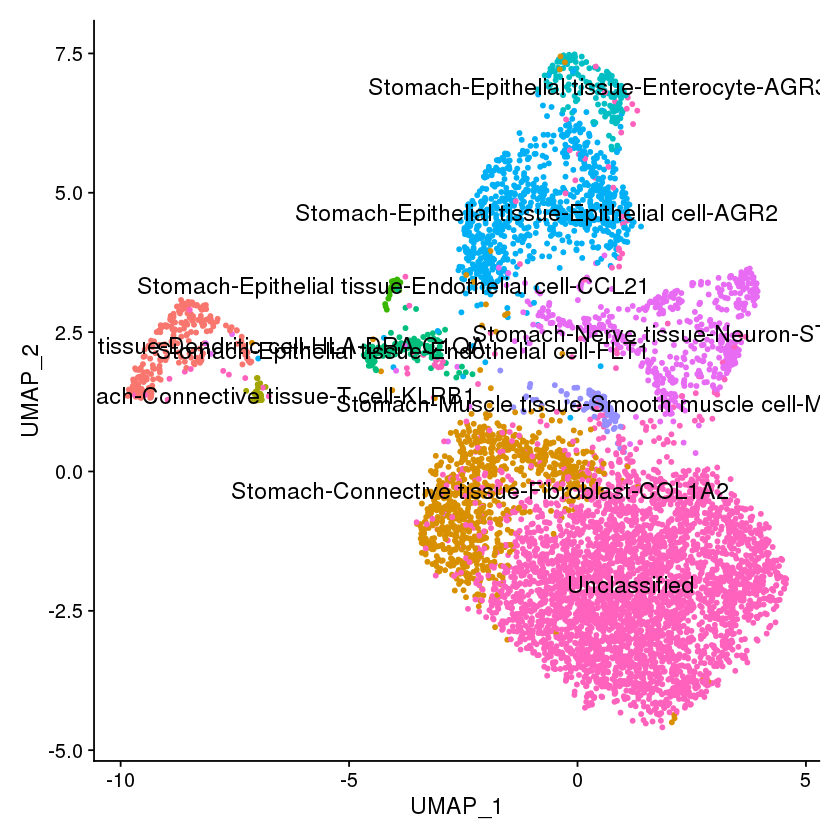

In [16]:
UMAPPlot(dataobj,label = T, pt.size=1,label.size=5,group.by='hcadv1name')+NoLegend()

In [ ]:
dataobj <- RunUMAP(dataobj,dims=1:pcDim)

In [8]:
dataobj = readRDS(file = paste0(datasetName,".seuratobj.rds"))

In [37]:
# ncol(result_data_out
print(levels(dataobj$sample_status))
levels(dataobj$donor_age)    

[1] "normal"


[1] "11W"

In [38]:
levels(dataobj$donor_age) <- c('GW11')

In [39]:
dataobj.dbupload_v1 <- CreateSeuratObject(result_data_out)
# dataobj.dbupload_v1 <- NormalizeData(dataobj.dbupload_v1, normalization.method = "LogNormalize", scale.factor = 10000)
dataobj.dbupload_v1[['orig.ident']] <- NULL
dataobj.dbupload_v1[['nCount_RNA']] <- NULL
dataobj.dbupload_v1[['nFeature_RNA']] <- NULL
dataobj.dbupload_v1$user_id <- 1
dataobj.dbupload_v1$study_id<-"10.1038/s41586-020-2157-4"
dataobj.dbupload_v1$cell_id <- colnames(dataobj.dbupload_v1@assays$RNA@data)
dataobj.dbupload_v1$organ<-"Stomach"
dataobj.dbupload_v1$region<-"NA"
dataobj.dbupload_v1$subregion<-"NA"
dataobj.dbupload_v1$seq_tech<-"Microwell-seq"
dataobj.dbupload_v1$sample_status<-"Healthy"
dataobj.dbupload_v1$donor_id<-dataobj$donor_ID
dataobj.dbupload_v1$donor_gender<-dataobj$donor_gender
dataobj.dbupload_v1$donor_age<- dataobj$donor_age
dataobj.dbupload_v1$original_name<-dataobj$cell_cluster
dataobj.dbupload_v1$cl_name<-"NA"
dataobj.dbupload_v1$hcad_name<-dataobj$hcad.label

In [40]:
dataobj.dbupload_v1$original_name<-as.character(dataobj.dbupload_v1$original_name)
dataobj.dbupload_v1$donor_id<-as.character(dataobj.dbupload_v1$donor_id)
dataobj.dbupload_v1$donor_gender<-as.character(dataobj.dbupload_v1$donor_gender)
dataobj.dbupload_v1$donor_age<- sub("Y","yr",dataobj.dbupload_v1$donor_age)


In [13]:
saveRDS(dataobj.dbupload_v1, file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [42]:
ncol(dataobj.dbupload_v1@meta.data)
colnames(dataobj.dbupload_v1@meta.data)

[1] 14

[1] "user_id"       "study_id"      "cell_id"       "organ"        
 [5] "region"        "subregion"     "seq_tech"      "sample_status"
 [9] "donor_id"      "donor_gender"  "donor_age"     "original_name"
[13] "cl_name"       "hcad_name"

In [43]:
dataobj.dbupload_v1

An object of class Seurat 
43878 features across 6475 samples within 1 assay 
Active assay: RNA (43878 features, 0 variable features)

In [44]:
head(dataobj.dbupload_v1[[]],3)

,user_id,study_id,cell_id,organ,region,subregion,seq_tech,sample_status,donor_id,donor_gender,donor_age,original_name,cl_name,hcad_name
,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
FetalStomach_2.CTGTGTTTTAGGGTGGTA,1,10.1038/s41586-020-2157-4,FetalStomach_2.CTGTGTTTTAGGGTGGTA,Stomach,NA,NA,Microwell-seq,Healthy,6,Female,GW11,Stomach fundus cell,NA,Stomach-Epithelial tissue-Epithelial cell-AGR2
FetalStomach_2.AAGCGGTAGTCGGAATTA,1,10.1038/s41586-020-2157-4,FetalStomach_2.AAGCGGTAGTCGGAATTA,Stomach,NA,NA,Microwell-seq,Healthy,3,Female,GW11,Epithelial cell,NA,Stomach-Epithelial tissue-Epithelial cell-AGR2
FetalStomach_2.CAAAGTTAGAGAAGCGAG,1,10.1038/s41586-020-2157-4,FetalStomach_2.CAAAGTTAGAGAAGCGAG,Stomach,NA,NA,Microwell-seq,Healthy,3,Female,GW11,Epithelial cell,NA,Stomach-Epithelial tissue-Epithelial cell-AGR2


In [3]:
dataobj.dbupload_v1 <- readRDS(file = paste0(datasetName,".seuratobj.dbupload_v1.rds"))

In [4]:
unique(dataobj.dbupload_v1[['cell_type']])

,cell_type
,<chr>
FetalStomach_2.CTGTGTTTTAGGGTGGTA,Epithelial cell
FetalStomach_2.GCGTCCCAAAGTTGATCA,Enterocyte
FetalStomach_2.AACCTATGGATGATTCCA,Fibroblast
FetalStomach_2.ACGTTGTCGGGTCGCTTG,Neuron
FetalStomach_2.GAGGAGTGTCACAGATGG,Dendritic cell
FetalStomach_2.GGACATAACCTATAAGGG,Endothelial cell
FetalStomach_2.TGATCAACGAGCTCGTAA,Smooth muscle cell
FetalStomach_2.CGAGTATAGCATTCGGGT,T cell
